# MNIST Digit Addition Problem

Consider a task where one needs to learn a classifier $\mathtt{addition(X,Y,N)}$ where $\mathtt{X}$ and $\mathtt{Y}$ are images of digits (the MNIST data set will be used), and $\mathtt{N}$ is a natural number corresponding to the sum of these digits. The classifier should return an estimate of the validity of the addition ($0$ is invalid, $1$ is valid). 

For instance, if $\mathtt{X}$ is an image of a 0 and $\mathtt{Y}$ is an image of a 9:
- if $\mathtt{N} = 9$, then the addition is valid; 
- if $\mathtt{N} = 4$, then the addition is not valid. 

A natural approach is to seek to first 1) learn a single digit classifier, then 2) benefit from knowledge readily available about the properties of addition.
For instance, suppose that a predicate $\mathrm{digit}(x,d)$ gives the likelihood of an image $x$ being of digit $d$, one could query with LTN:    
$$
\exists d_1,d_2 : d_1+d_2= \mathtt{N} \ (\mathrm{digit}(\mathtt{X},d_1)\land \mathrm{digit}(\mathtt{Y},d_2))
$$
and use the satisfaction of this query as the output of $\mathtt{addition(X,Y,N)}$ .


The challenge is the following:
- We provide, in the data, pairs of images $\mathtt{X}$, $\mathtt{Y}$ and the result of the addition $\mathtt{N}$ (final label),
- We do **not** provide the intermediate labels, the correct digits for $d_1$, $d_2$.

Regardless, it is possible to use the equation above as background knowledge to train $\mathrm{digit}$ with LTN.
In contrast, a standard neural network baseline cannot incorporate such intermediate components as nicely.

In [1]:
import tensorflow as tf
import ltn
import baselines, data, commons
import matplotlib.pyplot as plt

Init Plugin
Init Graph Optimizer
Init Kernel


## Data

Dataset of images for the digits X and Y, and their label Z s.t. X+Y=Z.

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Result label is 5


2022-06-23 12:36:23.129177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-23 12:36:23.129682: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


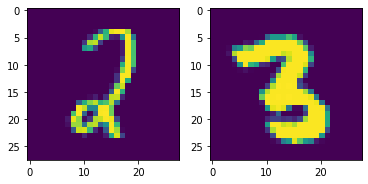

In [2]:
ds_train, ds_test = data.get_mnist_op_dataset(
        count_train=3000,
        count_test=1000,
        buffer_size=3000,
        batch_size=16,
        n_operands=2,
        op=lambda args: args[0]+args[1])

# Visualize one example
x, y, z = next(ds_train.as_numpy_iterator())
plt.subplot(121)
plt.imshow(x[0][:,:,0])
plt.subplot(122)
plt.imshow(y[0][:,:,0])
print("Result label is %i" % z[0])

## LTN

In [3]:
logits_model = baselines.SingleDigit()
Digit = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model))

d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))

Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

Notice the use of `Diag`: when grounding $x$,$y$,$n$ with three sequences of values, the $i$-th examples of each variable are matching. 
That is, `(images_x[i],images_y[i],labels[i])` is a tuple from our dataset of valid additions.
Using the diagonal quantification, LTN aggregates pairs of images and their corresponding result, rather than any combination of images and results. 
    
Notice also the guarded quantification: by quantifying only on the "intermediate labels" (not given during training) that could add up to the result label (given during training), we incorporate symbolic information into the system.

In [4]:
# mask
add = ltn.Function.Lambda(lambda inputs: inputs[0]+inputs[1])
equals = ltn.Predicate.Lambda(lambda inputs: inputs[0] == inputs[1])

### Axioms
@tf.function
def axioms(images_x, images_y, labels_z, p_schedule=tf.constant(2.)):
    images_x = ltn.Variable("x", images_x)
    images_y = ltn.Variable("y", images_y)
    labels_z = ltn.Variable("z", labels_z)
    axiom = Forall(
            ltn.diag(images_x,images_y,labels_z),
            Exists(
                (d1,d2),
                And(Digit([images_x,d1]),Digit([images_y,d2])),
                mask=equals([add([d1,d2]), labels_z]),
                p=p_schedule
            ),
            p=2
        )
    sat = axiom.tensor
    return sat

images_x, images_y, labels_z = next(ds_train.as_numpy_iterator())
axioms(images_x, images_y, labels_z)

2022-06-23 12:36:26.453138: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-23 12:36:26.458014: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-23 12:36:26.458474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


<tf.Tensor: shape=(), dtype=float32, numpy=0.011127114>

Optimizer, training steps and metrics

In [5]:
optimizer = tf.keras.optimizers.Adam(0.001)
metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy")    
}

@tf.function
def train_step(images_x, images_y, labels_z, **parameters):
    # loss
    with tf.GradientTape() as tape:
        loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    gradients = tape.gradient(loss, logits_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
    metrics_dict['train_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model(images_x),axis=-1)
    predictions_y = tf.argmax(logits_model(images_y),axis=-1)
    predictions_z = predictions_x + predictions_y
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    
@tf.function
def test_step(images_x, images_y, labels_z, **parameters):
    # loss
    loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    metrics_dict['test_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model(images_x),axis=-1)
    predictions_y = tf.argmax(logits_model(images_y),axis=-1)
    predictions_z = predictions_x + predictions_y
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))

Training

In [6]:
from collections import defaultdict

scheduled_parameters = defaultdict(lambda: {})
for epoch in range(0,4):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(1.)}
for epoch in range(4,8):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(2.)}
for epoch in range(8,12):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(4.)}
for epoch in range(12,20):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(6.)}


In [7]:
commons.train(
    20,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    scheduled_parameters=scheduled_parameters
)

2022-06-23 12:36:30.409783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-23 12:36:39.120105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-23 12:36:39.490875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-23 12:36:40.668465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 0, train_loss: 0.9236, train_accuracy: 0.4724, test_loss: 0.8675, test_accuracy: 0.7331
Epoch 1, train_loss: 0.8493, train_accuracy: 0.8760, test_loss: 0.8530, test_accuracy: 0.8095
Epoch 2, train_loss: 0.8403, train_accuracy: 0.9136, test_loss: 0.8433, test_accuracy: 0.8591
Epoch 3, train_loss: 0.8353, train_accuracy: 0.9375, test_loss: 0.8411, test_accuracy: 0.8730
Epoch 4, train_loss: 0.6387, train_accuracy: 0.9302, test_loss: 0.6627, test_accuracy: 0.8532
Epoch 5, train_loss: 0.6306, train_accuracy: 0.9408, test_loss: 0.6467, test_accuracy: 0.8869
Epoch 6, train_loss: 0.6230, train_accuracy: 0.9521, test_loss: 0.6383, test_accuracy: 0.9048
Epoch 7, train_loss: 0.6195, train_accuracy: 0.9608, test_loss: 0.6351, test_accuracy: 0.9077
Epoch 8, train_loss: 0.4232, train_accuracy: 0.9555, test_loss: 0.4631, test_accuracy: 0.8988
Epoch 9, train_loss: 0.4286, train_accuracy: 0.9475, test_loss: 0.4665, test_accuracy: 0.8938
Epoch 10, train_loss: 0.4176, train_accuracy: 0.9601, test_l